In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.linalg import solve, solve_discrete_are, solve_discrete_lyapunov, LinAlgError
from numpy.linalg import inv, norm, eigvals
import matplotlib.pyplot as plt
from sys import stdout
from mpl_toolkits.mplot3d import Axes3D

System matrices initializations

In [2]:
PLAYER = 2

In [3]:
#helper functions for system matrices generation

n = PLAYER

def psd(n):
    """generate PSD matrix with dimension n-by-n"""
    mat = np.random.normal(0, 1, (n, n))
    return mat.T@mat

def normed_psd(n):
    """random PSD matrix with all eigvals within the unit circle"""
    psd_m = psd(n)
    return psd_m/(LA.norm(psd_m)*2)

def heuristic_X(n):
    """generate potentially more stable X_matrix by applying some heuristics"""
    X_list = []
    X_min_eigval = []
    min_eigval = 0
    while min_eigval < 0.1 and len(X_list) < 10000:
        X = normed_psd(n)
        X_list.append(X)
        try:
            assert np.all(LA.eigvals(X) > 0)
        except AssertionError:
            continue
        curr_X_eigval = LA.eigvals(X)
        X_min_eigval.append(min(curr_X_eigval))
        if min(curr_X_eigval) > min_eigval:
            min_eigval = min(curr_X_eigval)
    X_index = np.argmax(X_min_eigval)
    X = X_list[X_index]
    return X

def K_generator(A_matrix, X_matrix):
    """Given system matrix, apply heuristics to generate stabilizing diagonal K matrix"""
    K_heuristic_list = []
    eigenvals_list = []
    min_eig = 3
    n = A_matrix.shape[0]
    while min_eig > 0.89 and len(K_heuristic_list) < 200:
        K = np.diag(np.random.random_sample(n))
        K_heuristic_list.append(K)
        system_matrix = A_matrix - X_matrix@K
        w_K = LA.eigvals(system_matrix)
        eigenvals_list.append(max(w_K))
    if max(w_K) < min_eig:
        min_eig = max(w_K)
    most_stable_index = np.argmin(eigenvals_list)
    K = K_heuristic_list[most_stable_index]
    return K

In [5]:
A = np.eye(PLAYER)
B = heuristic_X(PLAYER)
q_diag = np.random.randint(1, 10, size=PLAYER)
Q = np.diag(q_diag)
R = np.eye(PLAYER) * np.random.randint(1, 10, size=1)
r_diag = R.diagonal()
Q_dict = {}
B_dict = {}
for i in range(1, PLAYER+1):
    curr_q = np.zeros(PLAYER)
    curr_q[i-1] = q_diag[i-1]
    Q_dict[i] = np.diagflat(curr_q)
    B_i = np.zeros_like(B)
    B_i[:, i-1] = B[:, i-1]
    B_dict[i] = B_i

K_rand = K_generator(A, B)

In [6]:
#system check for n player case
print("A matrix is ", A)
print('\n')
print("B matrix is " + str(B) + " with \n")
for i in range(len(B_dict)):
    print("B{} = {}, \n".format(i+1, B_dict[i+1]))
print('\n')
print("Q matrix is " + str(Q) + " with \n")
for i in range(len(Q_dict)):
    print("Q{} = {}, \n".format(i+1, Q_dict[i+1]))
print('\n')
print("R matrix is ", R)

A matrix is  [[1. 0.]
 [0. 1.]]


B matrix is [[0.43299176 0.13080078]
 [0.13080078 0.16822736]] with 

B1 = [[0.43299176 0.        ]
 [0.13080078 0.        ]], 

B2 = [[0.         0.13080078]
 [0.         0.16822736]], 



Q matrix is [[2 0]
 [0 9]] with 

Q1 = [[2. 0.]
 [0. 0.]], 

Q2 = [[0. 0.]
 [0. 9.]], 



R matrix is  [[7. 0.]
 [0. 7.]]


In [7]:
X_inv = LA.inv(B)

In [8]:
#if we set k1 to be fixed, find the area segment of (k2, k3, k...) to minimize over
gap = 100

iter_points = []
k1 = 10
K_list = np.ones(PLAYER) #initialize each ki in the list, which is 0-indexed
K_list[0] = k1

while abs(gap) > 1e-5:
    min_k_dict = {1: (k1, 10000, 10000)} #1-indexed
    for i in range(2, PLAYER+1):
        min_k_dict[i] = (100000, 10000, 100000) #(ki, cost, Pi)

    #with the first agent fixed, for each rest of the agent:
    for j in range(0, len(K_list)):
        for curr_kj in np.arange(0.1, 20, 0.1):
            curr_K = K_list.copy()
            curr_K[j] = curr_kj
            K = np.diag(curr_K)
            if np.all(LA.eigvals(K-2*X_inv) < 0):
                Ak = A - B@K
                Pj = solve_discrete_lyapunov(Ak, Q_dict[j+1])

                cost = np.trace(Pj)
                if cost < min_k_dict[j+1][1]:
                    min_k_dict[j+1] = (curr_kj, cost, Pj)
                    #iter_points.append((K_list, min_k_dict[j+1][1], j))
            # else:
            #     break
        K_list[j] = min_k_dict[j+1][0]
        print("curr P matrix for {}th agent is :".format(j+1), min_k_dict[j+1][-1])
        iter_points.append((K_list.copy(), min_k_dict[j+1][1], j))

    for k1 in np.arange(0.1, 20, 0.1):
        curr_K = K_list.copy()
        curr_K[0] = k1
        K = np.diag(curr_K)
        if np.all(LA.eigvals(K-2*X_inv) < 0):
            Ak = A - B@K
            P1 = solve_discrete_lyapunov(Ak, Q_dict[1])
            cost = np.trace(P1)
            if cost < min_k_dict[1][1]:
                min_k_dict[1] = (k1, cost, P1)
    K_list[0] = min_k_dict[1][0]
    iter_points.append((K_list.copy(),  min_k_dict[1][1], 0))
    print("curr P matrix for the first agent is :", min_k_dict[1][-1])
    p1 = iter_points[-1][0]
    p2 = iter_points[-2][0]
    gap = LA.norm(np.subtract(p1, p2))


curr P matrix for 1th agent is : [[ 2.01829216 -0.11479629]
 [-0.11479629  0.72068391]]
curr P matrix for 2th agent is : [[ 3.6293201  -1.83382594]
 [-1.83382594 10.15659511]]
curr P matrix for the first agent is : [[ 2.07525974 -0.06822865]
 [-0.06822865  0.19276718]]


In [9]:
iter_points

[(array([2.2, 1. ]), 2.7389760709994424, 0),
 (array([2.2, 4.5]), 13.785915207128989, 1),
 (array([2.2, 4.5]), 2.268026918855261, 0)]

In [10]:
K = np.diag(iter_points[-1][0])
Ak = A - B@K
P = solve_discrete_lyapunov(Ak, Q)
np.trace(P)

16.05394212598425

In [11]:
P

array([[ 5.70457984, -1.90205459],
       [-1.90205459, 10.34936229]])

In [31]:
%matplotlib inline

global min point is  (0.9, 0.9, 95.84807538771722)
global min cost  95.84807538771722


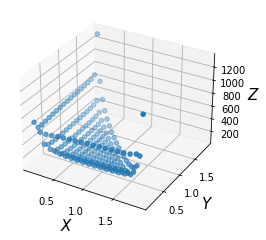

In [32]:
#grid search for 2 player 
if PLAYER == 2:
    X_inv = LA.inv(B)
    points = []
    cost_list = []
    for k1 in np.arange(0, 20, 0.1):
        for k2 in np.arange(0, 20, 0.1):
            K = np.diag([k1, k2])
            Ak = A-B@np.diag([k1, k2])
            if np.all(LA.eigvals(K-2*X_inv) < 0):
                try:
                    P = solve_discrete_lyapunov(Ak, Q)
                    cost = np.trace(P)
                    points.append((k1, k2, cost))
                    cost_list.append(cost)
                except LinAlgError:
                    continue
    p_x = [x[0] for x in points]
    p_y = [x[1] for x in points]
    p_z = [x[2] for x in points]
    # plt.scatter(p_x, p_y)


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = p_x, p_y, p_z
    ax.scatter(x, y, z)

    ax.set_xlabel('$X$', fontsize=15)
    ax.set_ylabel('$Y$', fontsize=15)
    ax.set_zlabel(r'$Z$', fontsize=15)

    print("global min point is ", points[np.argmin(cost_list)])
    print("global min cost ", np.min(cost_list))

if PLAYER == 3:
    points = []
    cost_list = []
    for k1 in np.arange(0, 10, 0.1):
        print(k1, end=' ')
        for k2 in np.arange(0, 10, 0.1):
            for k3 in np.arange(0, 10, 0.1):
                K = np.diag([k1, k2, k3])
                Ak = A-B@K
                if np.all(LA.eigvals(K-2*X_inv) < 0):
                    try:
                        P = solve_discrete_lyapunov(Ak, Q)
                        points.append((k1, k2, k3))
                        cost_list.append(np.trace(P))
                    except LinAlgError:
                        continue

    p_x = [x[0] for x in points]
    p_y = [x[1] for x in points]
    p_z = [x[2] for x in points]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = p_x, p_y, p_z
    ax.scatter(x, y, z)

    ax.set_xlabel('$X$', fontsize=15)
    ax.set_ylabel('$Y$', fontsize=15)
    ax.set_zlabel(r'$Z$', fontsize=15)


In [33]:
points

[(0.1, 0.1, 721.64216208538),
 (0.1, 0.2, 596.6483266137809),
 (0.1, 0.30000000000000004, 591.4526876860822),
 (0.1, 0.4, 599.9212985657238),
 (0.1, 0.5, 609.5163282681547),
 (0.1, 0.6000000000000001, 618.139391790956),
 (0.1, 0.7000000000000001, 625.5668280339557),
 (0.1, 0.8, 631.9564114005085),
 (0.1, 0.9, 637.5240217617094),
 (0.1, 1.0, 642.4734346227028),
 (0.1, 1.1, 646.9900525438128),
 (0.1, 1.2000000000000002, 651.254436322456),
 (0.1, 1.3, 655.4687996157627),
 (0.1, 1.4000000000000001, 659.9073156054782),
 (0.1, 1.5, 665.0310819963069),
 (0.1, 1.6, 671.8165906982448),
 (0.1, 1.7000000000000002, 683.0154016902457),
 (0.1, 1.8, 711.3138990802938),
 (0.1, 1.9000000000000001, 1313.3620469994755),
 (0.2, 0.1, 596.6483266137817),
 (0.2, 0.2, 362.90706598768963),
 (0.2, 0.30000000000000004, 314.16894273386197),
 (0.2, 0.4, 300.89840827936774),
 (0.2, 0.5, 298.1077990013611),
 (0.2, 0.6000000000000001, 299.0232410010291),
 (0.2, 0.7000000000000001, 301.343678602565),
 (0.2, 0.8, 304.1

In [28]:
global_opt = points[np.argmin(cost_list)]
global_min_cost = np.min(cost_list)
print("global optimal point is located at {} with cost {}".format(global_opt, global_min_cost))

global optimal point is located at (0.9, 0.9) with cost 95.84807538771722


## Checking for Variational inequality

In [34]:
for i in range(100000):
    if i % 1000 == 0:
        print('=', end='')
    print('=', end='')
    K_1 = K_generator(A, B)
    K_2 = K_generator(A, B)
    Ak_1 = A - B@K_1
    Ak_2 = A - B@K_2

    P1_1 = solve_discrete_lyapunov(Ak_1, Q_dict[1])
    P2_1 = solve_discrete_lyapunov(Ak_1, Q_dict[2])


    P1_2 = solve_discrete_lyapunov(Ak_2, Q_dict[1])
    P2_2 = solve_discrete_lyapunov(Ak_2, Q_dict[2])

    X0_1 = solve_discrete_lyapunov(Ak_1.T, np.eye(n))
    X0_2 = solve_discrete_lyapunov(Ak_2.T, np.eye(n))


    D1_1 = (-2*B_dict[1]@P1_1@Ak_1@X0_1)[0][0]
    D2_1 = (-2*B_dict[2]@P2_1@Ak_1@X0_1)[1][1]
    F_1 = np.array([D1_1, D2_1])

    D1_2 = (-2*B_dict[1]@P1_2@Ak_2@X0_2)[0][0]
    D2_2 = (-2*B_dict[2]@P2_2@Ak_2@X0_2)[1][1]
    F_2 = np.array([D1_2, D2_2])

    assert (F_1 - F_2)@(K_1 - K_2).diagonal() > LA.norm((K_1 - K_2).diagonal())**2

## plotting for different alpha

In [91]:
delta_list = []
cost_diff_list = []

# A = np.eye(PLAYER)
# q_diag = np.random.randint(1, 10, size=PLAYER)
# Q = np.diag(q_diag)
# R = np.eye(PLAYER) * np.random.randint(1, 10, size=1)
# r_diag = R.diagonal()
# Q_dict = {}
# for i in range(1, PLAYER+1):
#     curr_q = np.zeros(PLAYER)
#     curr_q[i-1] = q_diag[i-1]
#     Q_dict[i] = np.diagflat(curr_q)

for alpha in np.arange(0, 0.5, 0.01):
    print('=', end='')
    # for beta in np.arange(0, 1, 0.1):
    B = np.array([[1, alpha, alpha], [alpha, 1, alpha], [alpha, alpha, 1]])
    B_dict = {}
    for i in range(1, PLAYER+1):
        B_i = np.zeros_like(B)
        B_i[:, i-1] = B[:, i-1]
        B_dict[i] = B_i
    K_rand = K_generator(A, B)
    X_inv = LA.inv(B)

    gap = 100
    iter_points = []
    k1 = 0.5
    K_list = np.ones(PLAYER) #initialize each ki in the list, which is 0-indexed
    K_list[0] = k1

    while gap > 1e-5:
        A_tilda = A - B_dict[1]*K_list[0]
        min_k_dict = {1: (k1, 10000, 10000)} #1-indexed
        for i in range(2, PLAYER+1):
            min_k_dict[i] = (100000, 10000, 100000) #(ki, cost, Pi)
        for j in range(1, len(K_list)):
            for curr_kj in np.arange(0.1, 20, 0.1):
                curr_K = K_list.copy()
                curr_K[j] = curr_kj
                K = np.diag(curr_K)
                if np.all(LA.eigvals(K-2*X_inv) < 0):
                    Ak = A - B@K
                    Pj = solve_discrete_lyapunov(Ak, Q_dict[j+1])
                    cost = np.trace(Pj)
                    if cost < min_k_dict[j+1][1]:
                        min_k_dict[j+1] = (K_list[j], cost, Pj)
                        #iter_points.append((K_list, min_k_dict[j+1][1], j))
                # else:
                #     break
            K_list[j] = min_k_dict[j+1][0]
            iter_points.append((K_list.copy(), min_k_dict[j+1][1], j))

            for k1 in np.arange(0.1, 20, 0.1):
                curr_K = K_list.copy()
                curr_K[0] = k1
                K = np.diag(curr_K)
                if np.all(LA.eigvals(K-2*X_inv) < 0):
                    Ak = A - B@K
                    P1 = solve_discrete_lyapunov(Ak, Q_dict[1])
                    cost = np.trace(P1)
                    #print(curr_K)
                    if cost < min_k_dict[1][1]:
                        min_k_dict[1] = (k1, cost, P1)
            K_list[0] = min_k_dict[1][0]
            iter_points.append((K_list.copy(),  min_k_dict[1][1], 0))
        p1 = iter_points[-1][0]
        p2 = iter_points[-2][0]
        gap = LA.norm(np.subtract(p1, p2))

    local_opt = iter_points[-1][0]

    K = np.diag(local_opt)
    Ak = A - B@K
    P = solve_discrete_lyapunov(Ak, Q)
    local_min_cost = np.trace(P)
    print("local opt is {} with cost {}".format(local_opt, local_min_cost))

    #grid search
    X_inv = LA.inv(B)
    points = []
    cost_list = []

    for k1 in np.arange(0, 10, 0.1):
        for k2 in np.arange(0, 10, 0.1):
            for k3 in np.arange(0, 10, 0.1):
                K = np.diag([k1, k2, k3])
                Ak = A-B@K
                if np.all(LA.eigvals(K-2*X_inv) < 0):
                    try:
                        P = solve_discrete_lyapunov(Ak, Q)
                        points.append((k1, k2, k3))
                        cost_list.append(np.trace(P))
                    except LinAlgError:
                        continue
    cost_list = [n for n in cost_list if n > 0]
    global_opt = points[np.argmin(cost_list)]

    global_min_cost = np.min(cost_list)
    print('global_min_cost = ', global_min_cost)
    delta = LA.norm(global_opt - local_opt) #location different
    cost_diff = (local_min_cost - global_min_cost)/global_min_cost #cost diff from global_min_cost(grid search)

    delta_list.append(delta)
    cost_diff_list.append(cost_diff)


=local opt is [1. 1. 1.] with cost 14.0
global_min_cost =  14.0
=local opt is [1. 1. 1.] with cost 14.00280084030812
global_min_cost =  14.00280084030812
=local opt is [1. 1. 1.] with cost 14.01121345974287
global_min_cost =  14.01121345974287
=local opt is [1. 1. 1.] with cost 14.02526826532478
global_min_cost =  14.02526826532478
=local opt is [1. 1. 1.] with cost 14.045016309509064
global_min_cost =  14.045016309509064
=local opt is [1. 1. 1.] with cost 14.070529860003543
global_min_cost =  14.070529860003543
=local opt is [1. 1. 1.] with cost 14.101903215211124
global_min_cost =  14.101903215211124
=local opt is [1. 1. 1.] with cost 14.139253783768947
global_min_cost =  14.139253783768947
=local opt is [1. 1. 1.] with cost 14.182723453088272
global_min_cost =  14.182723453088272
=local opt is [1. 1. 1.] with cost 14.232480279182418
global_min_cost =  14.232480279182418
=local opt is [1. 1. 1.] with cost 14.28872053872054
global_min_cost =  14.28872053872054
=local opt is [1. 1. 1.]

/Users/lijiayi/Documents/decentralized control/LQ game code/venv/lib/python3.8/site-packages/scipy/linalg/_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.17179e-17): result may not be accurate.
  x = solve(lhs, q.flatten())
/Users/lijiayi/Documents/decentralized control/LQ game code/venv/lib/python3.8/site-packages/scipy/linalg/_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.10618e-17): result may not be accurate.
  x = solve(lhs, q.flatten())


global_min_cost =  15.753731477001919
=local opt is [0.9 1.  1. ] with cost 16.20440234485845
global_min_cost =  15.90289402537509
=local opt is [0.9 1.  1. ] with cost 16.416151150691718
global_min_cost =  16.06151988770778
=local opt is [0.9 1.  1. ] with cost 16.644727378383227
global_min_cost =  16.22954236582222
=local opt is [0.8 1.  1. ] with cost 16.786985219823258
global_min_cost =  16.394919037995876
=local opt is [0.8 1.  1. ] with cost 17.01897118495168
global_min_cost =  16.569960449487336
=local opt is [0.8 1.  1. ] with cost 17.2682134717981
global_min_cost =  16.746767029471577
=local opt is [0.8 1.  1. ] with cost 17.536436265284614
global_min_cost =  16.92608098930796
=local opt is [0.8 1.  1. ] with cost 17.825644327737006
global_min_cost =  17.115098997445937
=local opt is [0.8 1.  1. ] with cost 18.138182919038854
global_min_cost =  17.301695373673105
=local opt is [0.8 1.  1. ] with cost 18.476814066123445
global_min_cost =  17.48903173535527
=local opt is [0.8 1.

Text(0.5, 1.0, 'dist between global opt and alg convergence point over alpha')

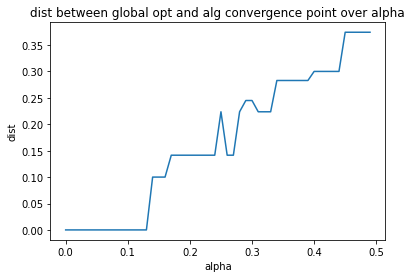

In [92]:
plt.plot(np.arange(0, 0.5, 0.01), delta_list)
plt.xlabel("alpha")
plt.ylabel("dist")
plt.title("dist between global opt and alg convergence point over alpha")

Text(0.5, 1.0, 'cost diff between global opt and alg convergence point over alpha in percentage')

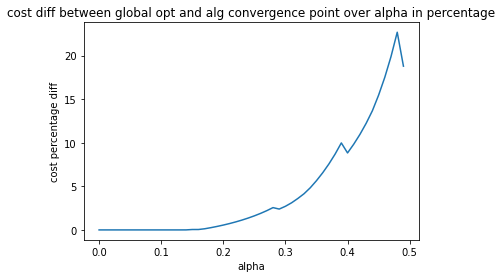

In [93]:
plt.plot(np.arange(0, 0.5, 0.01), np.multiply(cost_diff_list, 100))
plt.xlabel("alpha")
plt.ylabel("cost percentage diff")
plt.title("cost diff between global opt and alg convergence point over alpha in percentage")

In [94]:
np.multiply(cost_diff_list, 100)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.70056011e-03, 4.57864704e-02,
       4.75165587e-02, 1.31156426e-01, 2.59059920e-01, 4.00415992e-01,
       5.56467300e-01, 7.28622590e-01, 9.18484581e-01, 1.12788352e+00,
       1.35891775e+00, 1.61400316e+00, 1.89593365e+00, 2.20795582e+00,
       2.55820530e+00, 2.39138834e+00, 2.70978761e+00, 3.11371408e+00,
       3.60600470e+00, 4.15157009e+00, 4.83471433e+00, 5.64801040e+00,
       6.55314162e+00, 7.56428128e+00, 8.69866162e+00, 9.97743591e+00,
       8.82862101e+00, 9.83392062e+00, 1.09604499e+01, 1.22296096e+01,
       1.36680845e+01, 1.54545762e+01, 1.75075733e+01, 1.98864783e+01,
       2.26704112e+01, 1.87786203e+01])

2-player case

In [17]:
A = np.eye(PLAYER)
q_diag = np.random.randint(1, 2, size=PLAYER)
Q = np.diag(q_diag)
R = np.eye(PLAYER) * np.random.randint(1, 10, size=1)
r_diag = R.diagonal()
Q_dict = {}
for i in range(1, PLAYER+1):
    curr_q = np.zeros(PLAYER)
    curr_q[i-1] = q_diag[i-1]
    Q_dict[i] = np.diagflat(curr_q)


In [18]:
delta_list = []
cost_diff_list = []
#for 2 player B
for alpha in np.arange(0, 1, 0.01):
    print("=", end='')
    B = np.array([[1, alpha], [alpha, 1]])
    B_dict = {}
    
    for i in range(1, PLAYER+1):
        B_i = np.zeros_like(B)
        B_i[:, i-1] = B[:, i-1]
        B_dict[i] = B_i
    K_rand = K_generator(A, B)
    X_inv = LA.inv(B)
    
    gap = 100
    iter_points = []
    k1 = 0.5
    K_list = np.ones(PLAYER) #initialize each ki in the list, which is 0-indexed
    K_list[0] = k1

    while gap > 1e-5:
        A_tilda = A - B_dict[1]*K_list[0]
        min_k_dict = {1: (k1, 10000, 10000)} #1-indexed
        for i in range(2, PLAYER+1):
            min_k_dict[i] = (100000, 10000, 100000) #(ki, cost, Pi)
        for j in range(1, len(K_list)):
            for curr_kj in np.arange(0.1, 20, 0.1):
                curr_K = K_list.copy()
                curr_K[j] = curr_kj
                K = np.diag(curr_K)
                if np.all(LA.eigvals(K-2*X_inv) < 0):
                    Ak = A - B@K
                    Pj = solve_discrete_lyapunov(Ak, Q_dict[j+1])
                    cost = np.trace(Pj)
                    if cost < min_k_dict[j+1][1]:
                        min_k_dict[j+1] = (K_list[j], cost, Pj)
                        #iter_points.append((K_list, min_k_dict[j+1][1], j))
                # else:
                #     break
            K_list[j] = min_k_dict[j+1][0]
            iter_points.append((K_list.copy(), min_k_dict[j+1][1], j))

            for k1 in np.arange(0.1, 20, 0.1):
                curr_K = K_list.copy()
                curr_K[0] = k1
                K = np.diag(curr_K)
                if np.all(LA.eigvals(K-2*X_inv) < 0):
                    Ak = A - B@K
                    P1 = solve_discrete_lyapunov(Ak, Q_dict[1])
                    cost = np.trace(P1)
                    #print(curr_K)
                    if cost < min_k_dict[1][1]:
                        min_k_dict[1] = (k1, cost, P1)
            K_list[0] = min_k_dict[1][0]
            iter_points.append((K_list.copy(),  min_k_dict[1][1], 0))
        p1 = iter_points[-1][0]
        p2 = iter_points[-2][0]
        gap = LA.norm(np.subtract(p1, p2))

    local_opt = iter_points[-1][0]

    K = np.diag(local_opt)
    Ak = A - B@K
    P = solve_discrete_lyapunov(Ak, Q)
    local_min_cost = np.trace(P)
    print("local opt is {} with cost {}".format(local_opt, local_min_cost))
    
    #grid search 
    X_inv = LA.inv(B)
    points = []
    cost_list = []
    for k1 in np.arange(0, 20, 0.1):
        for k2 in np.arange(0, 20, 0.1):
            K = np.diag([k1, k2])
            Ak = A-B@np.diag([k1, k2])
            if np.all(LA.eigvals(K-2*X_inv) < 0):
                try:
                    P = solve_discrete_lyapunov(Ak, Q)
                    points.append((k1, k2))
                    cost_list.append(np.trace(P))
                except LinAlgError:
                    continue
    
    global_opt = points[np.argmin(cost_list)]
    global_min_cost = np.min(cost_list)
    delta = LA.norm(global_opt - local_opt) #location different 
    cost_diff = (local_min_cost - global_min_cost)/global_min_cost #cost diff from global_min_cost(grid search)

    print("global opt is {} with cost {}".format(global_opt, global_min_cost))

    delta_list.append(delta)
    cost_diff_list.append(cost_diff)

=local opt is [1. 1.] with cost 2.0
global opt is (1.0, 1.0) with cost 2.0
=local opt is [1. 1.] with cost 2.0002000200020005
global opt is (1.0, 1.0) with cost 2.0002000200020005
=local opt is [1. 1.] with cost 2.000800320128051
global opt is (1.0, 1.0) with cost 2.000800320128051
=local opt is [1. 1.] with cost 2.0018016214593133
global opt is (1.0, 1.0) with cost 2.0018016214593133
=local opt is [1. 1.] with cost 2.003205128205128
global opt is (1.0, 1.0) with cost 2.003205128205128
=local opt is [1. 1.] with cost 2.0050125313283207
global opt is (1.0, 1.0) with cost 2.0050125313283207
=local opt is [1. 1.] with cost 2.007226013649137
global opt is (1.0, 1.0) with cost 2.007226013649137
=local opt is [1. 1.] with cost 2.009848256456637
global opt is (1.0, 1.0) with cost 2.009848256456637
=local opt is [1. 1.] with cost 2.0128824476650564
global opt is (1.0, 1.0) with cost 2.0128824476650564
=local opt is [1. 1.] with cost 2.0163322915616493
global opt is (1.0, 1.0) with cost 2.01633

In [50]:
delta_list1 = delta_list
cost_diff_list1 = cost_diff_list

Text(0.5, 1.0, 'dist between global opt and alg convergence point over alpha')

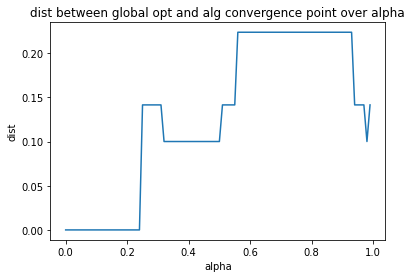

In [15]:
plt.plot(np.arange(0, 1, 0.01), delta_list)
plt.xlabel("alpha")
plt.ylabel("dist")
plt.title("dist between global opt and alg convergence point over alpha")

Text(0.5, 1.0, 'cost diff between global opt and alg convergence point over alpha in percentage')

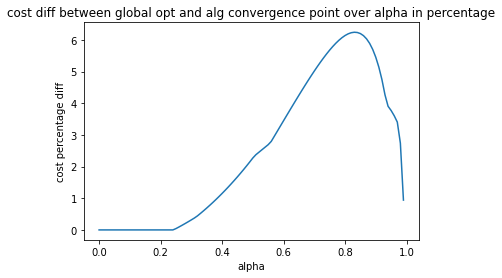

In [16]:
plt.plot(np.arange(0, 1, 0.01), np.multiply(cost_diff_list, 100))
plt.xlabel("alpha")
plt.ylabel("cost percentage diff")
plt.title("cost diff between global opt and alg convergence point over alpha in percentage")

Text(0.5, 1.0, 'dist between global opt and alg convergence point over alpha')

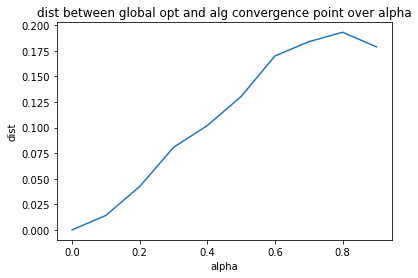

In [127]:
plt.plot(np.arange(0, 1, 0.1), delta_list)
plt.xlabel("alpha")
plt.ylabel("dist")
plt.title("dist between global opt and alg convergence point over alpha")

Text(0.5, 1.0, 'cost diff between global opt and alg convergence point over alpha in percentage')

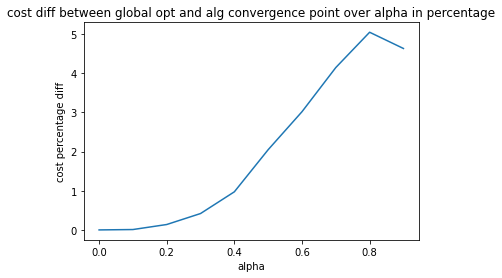

In [129]:
plt.plot(np.arange(0, 1, 0.1), np.multiply(cost_diff_list, 100))
plt.xlabel("alpha")
plt.ylabel("cost percentage diff")
plt.title("cost diff between global opt and alg convergence point over alpha in percentage")

## Search Algorithm

In [472]:
PLAYER = 3

In [473]:
A = np.eye(PLAYER)
B = heuristic_X(PLAYER) 

q_diag = np.random.randint(1, 10, size=PLAYER)
Q = np.diag(q_diag)
R = np.eye(PLAYER) * np.random.randint(1, 10, size=1)
r_diag = R.diagonal()
Q_dict = {}
B_dict = {}
for i in range(1, PLAYER+1):
    curr_q = np.zeros(PLAYER)
    curr_q[i-1] = q_diag[i-1]
    Q_dict[i] = np.diagflat(curr_q)
    B_i = np.zeros_like(B)
    B_i[:, i-1] = B[:, i-1]
    B_dict[i] = B_i

K_rand = K_generator(A, B)


In [474]:
#system check for 2 player case
print("A matrix is ", A)
print('\n')
print("B matrix is " + str(B) + " with \n")
for i in range(len(B_dict)):
    print("B{} = {}, \n".format(i+1, B_dict[i+1]))
print('\n')
print("Q matrix is " + str(Q) + " with \n")
for i in range(len(Q_dict)):
    print("Q{} = {}, \n".format(i+1, Q_dict[i+1]))
print('\n')
print("R matrix is ", R)

A matrix is  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


B matrix is [[0.2199242  0.06883739 0.06088398]
 [0.06883739 0.40280036 0.04966384]
 [0.06088398 0.04966384 0.13251917]] with 

B1 = [[0.2199242  0.         0.        ]
 [0.06883739 0.         0.        ]
 [0.06088398 0.         0.        ]], 

B2 = [[0.         0.06883739 0.        ]
 [0.         0.40280036 0.        ]
 [0.         0.04966384 0.        ]], 

B3 = [[0.         0.         0.06088398]
 [0.         0.         0.04966384]
 [0.         0.         0.13251917]], 



Q matrix is [[1 0 0]
 [0 7 0]
 [0 0 2]] with 

Q1 = [[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]], 

Q2 = [[0. 0. 0.]
 [0. 7. 0.]
 [0. 0. 0.]], 

Q3 = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 2.]], 



R matrix is  [[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]


In [475]:
mean = np.zeros(PLAYER)
cov = np.eye(PLAYER)
x0 = np.random.multivariate_normal(mean, cov, 1)

def simulate(v0, Ak, Q):
    c = 0
    v_curr = v0
    v_next = Ak@v_curr
    while LA.norm(v_next-v_curr) > 1e-3:
        c += v_next.T@Q@v_next
        v_curr = v_next
        v_next = Ak@v_curr
    return c

In [480]:
X_inv = LA.inv(B)
points = []
cost_list = []

if PLAYER == 2:
    for k1 in np.arange(0, 20, 0.01):
        for k2 in np.arange(0, 20, 0.01):
            K = np.diag([k1, k2])
            Ak = A-B@np.diag([k1, k2])
            if np.all(LA.eigvals(K-2*X_inv) < 0):
                try:
                    P = solve_discrete_lyapunov(Ak, Q)
                    points.append((k1, k2))
                    cost_list.append(np.trace(P))
                except LinAlgError:
                    continue  
            else:
                break

if PLAYER == 3: 
    for k1 in np.arange(0, 20, 0.1):
        print(k1, end=' ')
        for k2 in np.arange(0, 20, 0.1):
            for k3 in np.arange(0, 20, 0.1):
                K = np.diag([k1, k2, k3])
                Ak = A-B@K
                if np.all(LA.eigvals(K-2*X_inv) < 0):
                    try:
                        P = solve_discrete_lyapunov(Ak, Q)
                        points.append((k1, k2, k3))
                        cost_list.append(np.trace(P))
                    except LinAlgError:
                        continue  
                else:
                    break
                

0.0 0.1 0.2 0.30000000000000004 0.4 0.5 0.6000000000000001 0.7000000000000001 0.8 0.9 1.0 1.1 1.2000000000000002 1.3 1.4000000000000001 1.5 1.6 1.7000000000000002 1.8 1.9000000000000001 2.0 2.1 2.2 2.3000000000000003 2.4000000000000004 2.5 2.6 2.7 2.8000000000000003 2.9000000000000004 3.0 3.1 3.2 3.3000000000000003 3.4000000000000004 3.5 3.6 3.7 3.8000000000000003 3.9000000000000004 4.0 4.1000000000000005 4.2 4.3 4.4 4.5 4.6000000000000005 4.7 4.800000000000001 4.9 5.0 5.1000000000000005 5.2 5.300000000000001 5.4 5.5 5.6000000000000005 5.7 5.800000000000001 5.9 6.0 6.1000000000000005 6.2 6.300000000000001 6.4 6.5 6.6000000000000005 6.7 6.800000000000001 6.9 7.0 7.1000000000000005 7.2 7.300000000000001 7.4 7.5 7.6000000000000005 7.7 7.800000000000001 7.9 8.0 8.1 8.200000000000001 8.3 8.4 8.5 8.6 8.700000000000001 8.8 8.9 9.0 9.1 9.200000000000001 9.3 9.4 9.5 9.600000000000001 9.700000000000001 9.8 9.9 10.0 10.100000000000001 10.200000000000001 10.3 10.4 10.5 10.600000000000001 10.700000

In [482]:
p_x = [x[0] for x in points]
p_y = [x[1] for x in points]
p_z = [x[2] for x in points]

In [486]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


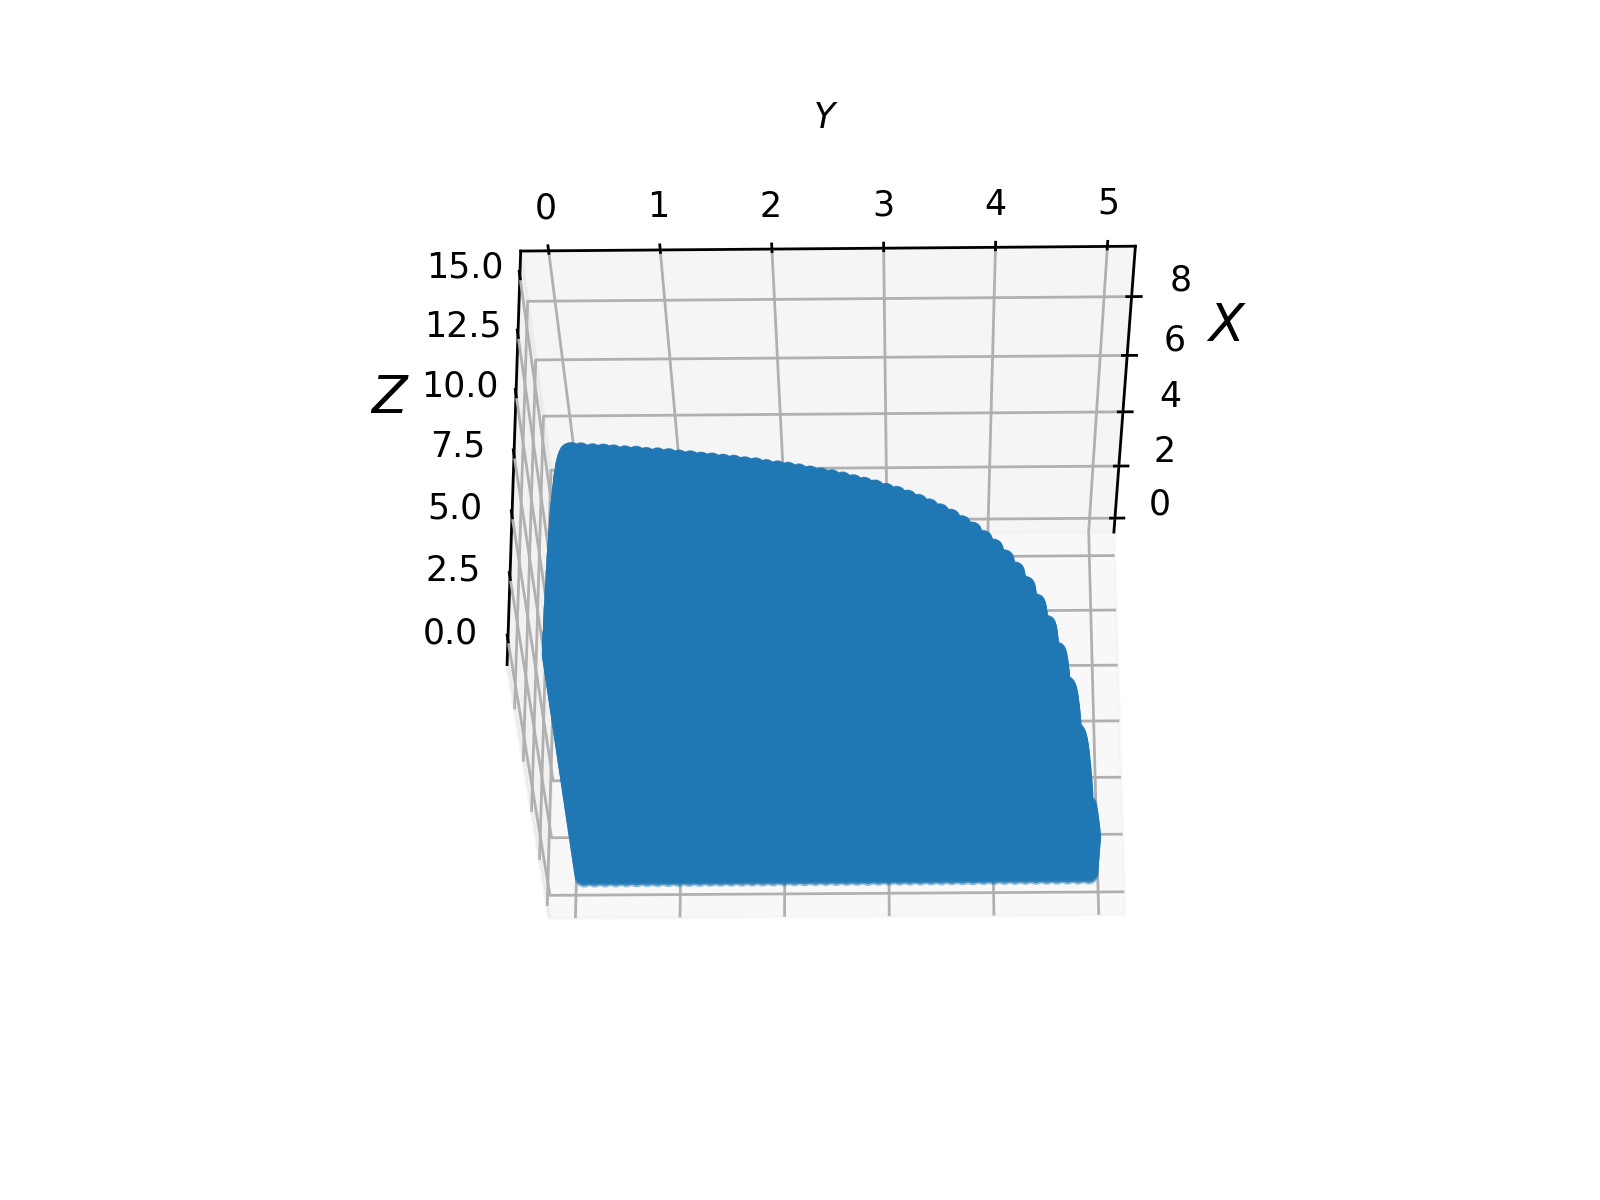

Text(0.5, 0, '$Z$')

In [490]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = p_x, p_y, p_z
ax.scatter(x, y, z)

ax.set_xlabel('$X$', fontsize=15)
ax.set_ylabel('$Y$', fontsize=15)
ax.set_zlabel(r'$Z$', fontsize=15)

In [491]:
np.argmin(cost_list)

237236

In [492]:
points[np.argmin(cost_list)]

(3.9000000000000004, 2.4000000000000004, 5.9)

In [493]:
min(cost_list)

11.147036627426552

In [410]:
points[557]

(0.0, 5.57)

In [443]:
cost_list[points.index((2.15, 4.88))]

5.713230204692438

In [432]:

k1_MAX, k2_MAX, K3_MAX = max(p_x), max(p_y), max(p_z)

In [494]:
X_inv

array([[ 5.36367234, -0.64248899, -2.22347658],
       [-0.64248899,  2.67985321, -0.70913909],
       [-2.22347658, -0.70913909,  8.83338398]])

In [499]:
import matplotlib.pyplot as plt
# plt.scatter(p_x, p_y)

In [ ]:
A_tilda

### for two players

In [441]:
#if we set k1 to be fixed, find the line segment of k2 to minimize over
ITER_NUM = 10
gap = 100
iter_points = []
k1 = 0.2
while gap > 1e-4:
    A_tilda = A - B1*k1
    min_k2 = (100000, 1000000, 100000)
    for k2 in np.arange(0.1, k2_MAX, 0.1):
        K = np.diag([k1, k2])
        if np.all(LA.eigvals(K-2*X_inv) < 0):
            Ak = A_tilda - B2*k2
            P2 = solve_discrete_lyapunov(Ak, Q2)
            cost = np.trace(P2)
            if cost < min_k2[1]:
                min_k2 = (k2, cost, P2)     
        else:
            break

    k2 = min_k2[0]
    iter_points.append((k1, k2, min_k2[1]))
    
    A_tilda = A - B2*k2
    min_k1 = (100000, 1000000, 100000)
    for k1 in np.arange(0.01, k1_MAX, 0.01):
        K = np.diag([k1, k2])
        if np.all(LA.eigvals(K-2*X_inv) < 0):
            Ak = A_tilda - B1*k1
            P1 = solve_discrete_lyapunov(Ak, Q1)
            cost = np.trace(P1)
            if cost < min_k1[1]:
                min_k1 = (k1, cost, P1)
        else:
            break
    k1 = min_k1[0]
    iter_points.append((k1, k2, min_k1[1]))
    p1 = iter_points[-1][0:2]
    p2 = iter_points[-2][0:2]
    gap = LA.norm(np.subtract(p1, p2))

In [442]:
iter_points

[(0.2, 5.03, 8.585552392431914),
 (2.15, 5.03, 1.0333646392815814),
 (2.15, 4.88, 4.6798528236650245),
 (2.15, 4.88, 1.0333773810274132)]

In [382]:
iter_points_x = [x[0] for x in iter_points]
iter_points_y = [x[1] for x in iter_points]

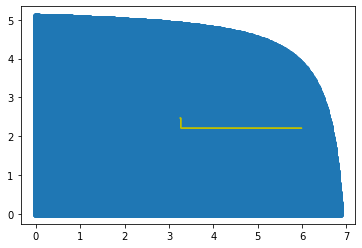

In [383]:
plt.scatter(p_x, p_y)
for i in range(len(iter_points_x)-1):
    plt.arrow(iter_points_x[i], iter_points_y[i], iter_points_x[i+1]-iter_points_x[i], iter_points_y[i+1]-iter_points_y[i], color='y')

### for three players or more 

In [502]:
B_dict

{1: array([[0.2199242 , 0.        , 0.        ],
        [0.06883739, 0.        , 0.        ],
        [0.06088398, 0.        , 0.        ]]),
 2: array([[0.        , 0.06883739, 0.        ],
        [0.        , 0.40280036, 0.        ],
        [0.        , 0.04966384, 0.        ]]),
 3: array([[0.        , 0.        , 0.06088398],
        [0.        , 0.        , 0.04966384],
        [0.        , 0.        , 0.13251917]])}

In [529]:
LA.eigvals(Ak)

array([ 1.        , -2.50305273,  1.        ])

In [525]:
np.all(LA.eigvals(K-2*X_inv) < 0)

True

In [544]:
#if we set k1 to be fixed, find the area segment of (k2, k3, k...) to minimize over
ITER_NUM = 10
gap = 100

iter_points = []
k1 = 1
K_list = np.ones(PLAYER) #initialize each ki in the list, which is 0-indexed 
K_list[0] = k1

while gap > 1e-5:
    A_tilda = A - B_dict[1]*K_list[0]
    min_k_dict = {1: (k1, 10000, 10000)} #1-indexed
    for i in range(2, PLAYER+1):
        min_k_dict[i] = (100000, 10000, 100000) #(ki, cost, Pi)
    for j in range(1, len(K_list)):
        for curr_kj in np.arange(0.1, 20, 0.1):
            curr_K = K_list
            curr_K[j] = curr_kj
            K = np.diag(curr_K)
            if np.all(LA.eigvals(K-2*X_inv) < 0):
                Ak = A - B@K #A_tilda - B2*k2
                Pj = solve_discrete_lyapunov(Ak, Q_dict[j+1])
                cost = np.trace(Pj)
                if cost < min_k_dict[j+1][1]:
                    min_k_dict[j+1] = (K_list[j], cost, Pj)   
            else:
                break
        K_list[j] = min_k_dict[j+1][0]
        iter_points.append((K_list, min_k_dict[j+1][1], j))
    
    for k1 in np.arange(0.1, 20, 0.1):
        curr_K = K_list
        curr_K[0] = k1
        K = np.diag(curr_K)
        if np.all(LA.eigvals(K-2*X_inv) < 0):
            Ak = A - B@K
            P1 = solve_discrete_lyapunov(Ak, Q_dict[1])
            cost = np.trace(P1)
            if cost < min_k_dict[1][1]:
                min_k_dict[1] = (k1, cost, P1) 
        else:
            break
    K_list[0] = min_k_dict[1][0]
    iter_points.append((K_list,  min_k_dict[1][1], 0))
    p1 = iter_points[-1][0]
    p2 = iter_points[-2][0]
    gap = LA.norm(np.subtract(p1, p2))
iter_points

[(array([4. , 2.4, 6.2]), 7.768183817227232, 1),
 (array([4. , 2.4, 6.2]), 3.218016518271088, 2),
 (array([4. , 2.4, 6.2]), 1.1802765484340567, 0)]

In [547]:
sum([inter_p[-2] for inter_p in iter_points[-PLAYER:]])

12.166476883932377

In [549]:
K = np.diag(iter_points[-1][0])
Ak = A - B@K
P = solve_discrete_lyapunov(Ak, Q)